This notebook is meant to provide Python tools to suppplement the OSU modsCCDRed software package (http://www.astronomy.ohio-state.edu/MODS/Software/modsCCDRed/) for preprocessing MODS 2D spectroscopic data, though these tools may also be helpful in broader use. Any improvements, additions, or changes are welcome! 

-Armaan Goyal

In [2]:
#import packages and set plotting style
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from scipy import optimize as op
from scipy import signal as sig
from scipy.ndimage.filters import gaussian_filter1d
plt.style.use(astropy_mpl_style)

This first primary function is meant to aid in the determination of trace centers in 2D spectra by plotting column-summed cross sectional plots of them and fitting Gaussian/Lorentzian profiles to the main trace. This task is meant to be interactive and predicated on some guess-and-check work, so it is recommended that DS9 is kept open with the intended file(s) to verify what is seen in these cross-sectional plots. 

In [5]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-1*((x-mu)**2)/(2*sigma**2))

def lorentzian(x, a, x0, gamma):
    return a/(1 + ((x - x0)/(gamma/2))**2)

def plot_trace(image_names, min_column, max_column, **kwargs):
    '''
    Function for plotting column-summed 2D spectra (.fits) and performing interactive smoothing and fitting of trace.
    
    Parameters:
    -----------
    image_names (list of strs): list of files to be plotted
    min_column/max_column (int): lower/upper bound of columns to sum 
    
    Optional Parameters:
    --------------------
    x_window/y_window (tuple of ints, 2): bounds for plotting window along horizontal/vertical axis
    separate_plots (bool): Toggle for separate/combined plots if image_names contains multiple files, default is True
    smooth (str): type of smoothing to be performed, "g" for Gaussian filter, "sg" for Savitzky-Golay smoothing
    sigma (float): Standard deviation for Gaussian filter
    window_size (int): Odd integer window size for Savitzky-Golay smoothing
    polynomial_order (int): Order of fitting polynomial for Savitsky-Golay smoothing
    fit (str): Profile to fit to trace, "g" for Gaussian, "l" for Lorentzian
    fit_window (tuple of ints, 2): bounds for fitting window
    guess (tuple of ints, 3): guess for fit parameters, (amplitude, mean, std. dev.) for Gauss, (amplitude, center, gamma) for Lorentzian
    
    Returns:
    --------
    plot(s) containing desired cross-sectional plots, as well as optional smoothed data and fit to trace.
    
    '''
    #Fetch global parameters
    sm = kwargs.get("smooth", None)
    f = kwargs.get("fit", None)
    g = kwargs.get("guess", (1000, 350, 1))
    sp = kwargs.get("separate_plots", True)
    sg_window = kwargs.get("window_size", 13)
    sg_order = kwargs.get("polynomial_order", 3)
    g_sigma = kwargs.get("sigma", 5)
    for i in range(len(image_names)):
        image_file = get_pkg_data_filename(image_names[i])
        image_data = fits.getdata(image_file, ext=0)
        summed = np.sum(image_data[:,min_column:max_column], axis = 1)
        plt.plot(summed, label = "Column-Summed Data for %s"%image_names[i])
        if sm:
            sp = True
            if sm == "sg":
                smoothed = sig.savgol_filter(summed, sg_window, sg_order)
                plt.plot(smoothed, ls = "--", label = "SG Smoothed Data for %s"%image_names[i])
                print("Savitzky-Golay filter applied with window size %d and polynomial order %d"%(sg_window, sg_order))
            if sm == "g":
                smoothed = gaussian_filter1d(summed, g_sigma)
                plt.plot(smoothed, ls = "--", label = "Gaussian Smoothed Data for %s"%image_names[i])
                print("Gaussian Filter applied with std. dev. %f"%(g_sigma))
            if f:
                f_w = kwargs.get("fit_window", (0, len(smoothed)))
                f_min = f_w[0]
                f_max = f_w[1]
                fit_region = np.arange(f_min, f_max, 1)
                if f == "g":
                    popt, pcov = op.curve_fit(gaussian, fit_region, smoothed[f_min:f_max], p0=[g[0], g[1], g[2]])
                    plt.plot(fit_region, gaussian(fit_region, popt[0], popt[1], popt[2]), label = "Gaussian Fit for Trace")
                    print("Trace approximated as Gaussian with center at pixel row %.2f and std. dev. %.2f"%(popt[1], popt[2]))
                if f == "l":
                    popt, pcov = op.curve_fit(lorentzian, fit_region, smoothed[f_min:f_max], p0=[g[0], g[1], g[2]])
                    plt.plot(fit_region, lorentzian(fit_region, popt[0], popt[1], popt[2]), label = "Lorentzian Fit for Trace")
                    print("Trace approximated as Lorentzian with center at pixel row %.2f and gamma of %.2f"%(popt[1], popt[2]))
        if sp:
            plt.ylabel('Pixel Counts')
            plt.xlabel('Row Along Spatial Axis')
            plt.title("Cross-Sectional Plot of 2D Spectrum for %s Summed Over Columns %d to %d"%(image_names[i], min_column, max_column))
            x_w = kwargs.get("x_window", (0, len(summed)))
            x_min = x_w[0]
            x_max = x_w[1]
            y_w = kwargs.get("y_window", (0, 1.25*np.max(summed)))
            y_min = y_w[0]
            y_max = y_w[1]
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend()
            plt.show()
    if not sp:
        plt.ylabel('Pixel Counts Summed Over Columns %d to %d'%(min_column, max_column))
        plt.xlabel('Row Along Spatial Axis')
        if x_w:
            plt.xlim(x_w[0], x_w[1])
        if y_w:
            plt.ylim(y_w[0], y_[1])
        plt.title("Cross-Sectional Plot of 2D Spectrum")
        plt.legend()
        plt.show()


Below are cells for both a first pass visualization of the trace and more specific fitting of the trace profile. You will probably have to adjust values and rerun the cells multiple times to find what you are looking for, and you will especially have to fiddle with the fitting parameters in the second cell to ensure a model with reasonable bounds and appearance.

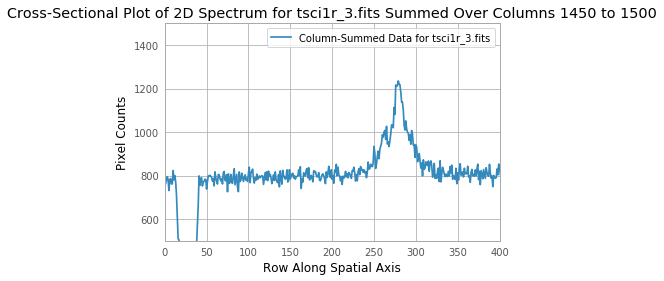

In [11]:
#simple visualization with no smoothing or fitting

image_list = ["tsci1r_3.fits"]
columns = (1450, 1500)
x_window = (0, 400)
y_window = (500, 1500)

plot_trace(['tsci1r_3.fits'], columns[0], columns[1], x_window = x_window, y_window = y_window)

Gaussian Filter applied with std. dev. 2.000000
Trace approximated as Lorentzian with center at pixel row 279.41 and gamma of 43.29


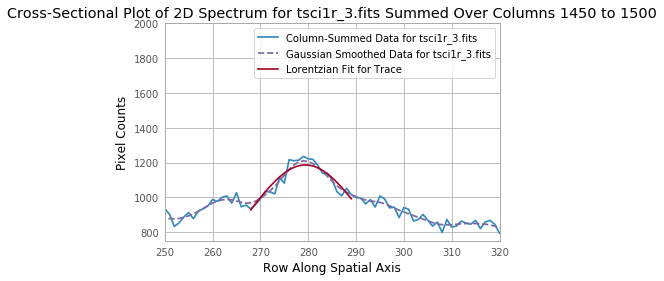

In [13]:
#smoothing and fitting added for trace profile estimation. See function docstrings for info on parameters.

image_list = ["tsci1r_3.fits"]
columns = (1450, 1500)
x_window = (250, 320)
y_window = (750, 2000)
smooth = "g"
sigma = 2
fit = "l"
guess = (2800, 275, 7)
fit_window = (268, 290)

plot_trace(image_list, columns[0], columns[1], x_window = x_window, y_window = y_window, smooth = smooth, sigma = sigma, fit = fit, guess = guess, fit_window = fit_window)

The following functions are for trimming and shifting the 2D spectra for further stacking or processing. 

In [16]:
import scipy
from skimage.feature import register_translation

def shift(filename, shift, save_as = False):
    '''
    Shifts image according to user input. Can perform image shifts at the sub-pixel level via FFT/IFFT. (Original Code by Dr. Kerry Paterson)
    
    Parameters:
    -----------
    filename (str): name of image
    shift (tuple): tuple of floats in form of (horizontal shift, vertical shift)
    save_as (str or bool, optional): desired filename of output, defaults to False (no saved output)
    
    Returns:
    --------
    shifted (arr): data array for shifted 2D image
    saves as new .fits file (with same header as input) if save_as name is provided
    
    '''
    #Retrieve file and load data into array
    image_file = get_pkg_data_filename(filename)
    image_data = fits.getdata(image_file, ext=0)
    
    #define bounds of dummy array that contains room for shfits (data size + pixel offset)
    N_x = image_data.shape[0] + int(abs(np.ceil(shift[1])))
    N_y = image_data.shape[1] + int(abs(np.ceil(shift[0])))
    f = np.zeros((N_x,N_y))
    f[:image_data.shape[0],:image_data.shape[1]] = image_data[:,:] #add the data to the new array
    
    #perform shift using FFTs (shift orientation is reversed due to Python reading arrays as row then column)
    shifted = np.fft.ifftn(scipy.ndimage.fourier_shift(np.fft.fftn(f),(shift[1], shift[0]))).real 
    
    #write shifted data to FITS file if desired
    if save_as:
        hdr = fits.getheader(filename, 0)
        fits.writeto(save_as, shifted, hdr, overwrite = True)
        print("%s shifted by (%.2f, %.2f). Saved as %s"%(filename, shift[0], shift[1], save_as))
    return shifted

def trim(filename, save_as = False, **kwargs):
    '''
    Simple image trimming routine.
    
    Parameters:
    -----------
    filename (str): name of image
    save_as (str or bool, optional): desired filename of output, defaults to False (no saved output)
    x_lim (tuple): horizontal range of desired trimmed images (if no input, will not trim)
    y_lim (tuple): vertical range of desired trimmed image (if no input, will not trim)
    
    Returns:
    --------
    image_data (arr): data array for trimmed 2D image
    saves as new .fits file (with same header as input) if save_as name is provided
    
    '''
    x_lim = kwargs.get("x_lim", (0, 8192))
    y_lim = kwargs.get("y_lim", (0, 3088))
    image_file = get_pkg_data_filename(filename)
    image_data = fits.getdata(image_file, ext=0)
    image_data = image_data[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
    #define bounds of dummy array that contains room for shfits (data size + pixel offset)
    N_y = y_lim[1] - y_lim[0]
    N_x = x_lim[1] - x_lim[0]
    f = np.zeros((N_y,N_x))
    f[:image_data.shape[0],:image_data.shape[1]] = image_data[:,:] #add the data to the new array
    #write shifted data to FITS file if desired
    if save_as:
        hdr = fits.getheader(filename, 0)
        fits.writeto(save_as, image_data, hdr, overwrite = True)
        print("%s trimmed horiz. to (%.2f, %.2f) and vert. to (%.2f, %.2f). Saved as %s"%(filename, x_lim[0], x_lim[1], y_lim[0], y_lim[1], save_as))
    return image_data

Code for trimming multiple images to same bounds, as is the case for processing MODS images (MODS color-specific trimming regions included):

In [17]:
def trim_all(image_list, x_lim, y_lim):
    for image in image_list:
        save_name = "t"+image+".fits"
        trim(image, save_as = save_name, x_lim = x_lim, y_lim = y_lim)

red = ["sci1r_1.fits", "sci1r_2.fits", "sci1r_3.fits", "std1r_1.fits", "std1r_2.fits", "std1r_3.fits"]
x_lim_red = (1400, 7400)
y_lim_red = (1255, 1855)
    
blue = ["sci1b_1.fits", "sci1b_2.fits", "sci1b_3.fits", "std1b_1.fits", "std1b_2.fits", "std1b_3.fits"]
x_lim_blue = (1450, 7450)
y_lim_blue = (1330, 1935)

Code for simulatenously shifting multiple exposures of a single object. Instead of explicitly passing in shifts, they are calculated automatically from a list of (x, y) tuples corresponding to traces/features that can be clearly identified in each exposure and matched between them (recommended to use either object or star trace as y coord. and common bright skyline as x coord.).

In [ ]:
def shift_all(image_list, loc_list):
    x_standard, y_standard = loc_list[0]
    for i in range(len(image_list)):
        x_loc, y_loc = loc_list[i]
        x_shift = x_standard - x_loc
        y_shift = y_standard - y_loc
        shifted_image = shift(image_list[i], (x_shift, y_shift), save_as = "s"+image_list[i])
        
shift_all(["tstd1r_1.fits", "tstd1r_2.fits", "tstd1r_3.fits"], [(0, 0), (0, 0), (0, 0)])